In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize

#Per fare dei bei grafici che si leggano
plt.rcParams.update({'font.size':14})

#Dataframe stocks
df_WEC = pd.read_csv("WEC.N.csv")
df_JNJ = pd.read_csv("JNJ.N.csv")
df_QCOM = pd.read_csv("QCOM.OQ.csv")
df_TDY = pd.read_csv("TDY.N.csv")
df_PEP = pd.read_csv("PEP.OQ.csv")

#Dataframe S&P500
df_SPX = pd.read_csv("SPX.csv")

## Punto 1


La prima parte si concentra sul data anlysis del campione, in particolare cerchiamo di capire quanti Nan ci sono e se si può fare dell'inferenza per capire come sostituire i valori.\
Controllo se ci sono Nan in ogni data set e visualizzo vari dati sul campione.

In [2]:
print("WEC Dataset\n")
print(df_WEC.info(),df_WEC.describe())
print("\nJNJ Dataset\n")
print(df_JNJ.info(),df_JNJ.describe())
print("\nQCOM Dataset\n")
print(df_QCOM.info(),df_QCOM.describe())
print("\nTDY Dataset\n")
print(df_TDY.info(),df_TDY.describe())
print("\nPEP Dataset\n")
print(df_PEP.info(),df_PEP.describe())


WEC Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            251 non-null    int64  
 1   Instrument            251 non-null    object 
 2   Date                  251 non-null    object 
 3   1 Month Total Return  251 non-null    float64
 4   Company Market Cap    251 non-null    float64
 5   Price Close           251 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 11.9+ KB
None        Unnamed: 0  1 Month Total Return  Company Market Cap  Price Close
count  251.000000            251.000000        2.510000e+02   251.000000
mean   125.000000              1.172101        1.498314e+10    51.694681
std     72.601653              4.611845        9.915640e+09    28.445197
min      0.000000            -13.569150        3.712649e+09    15.700000
25%     62.500000             -1.690880   

In [3]:
#Converto le date in un formato leggibile 
df_WEC['Date'] = pd.to_datetime(df_WEC['Date']).dt.date
df_JNJ['Date'] = pd.to_datetime(df_JNJ['Date']).dt.date
df_QCOM['Date'] = pd.to_datetime(df_QCOM['Date']).dt.date
df_TDY['Date'] = pd.to_datetime(df_TDY['Date']).dt.date
df_PEP['Date'] = pd.to_datetime(df_PEP['Date']).dt.date


print("Date CFG:\n",df_WEC['Date'])
print("\nDate JNJ:\n",df_JNJ["Date"])
print("\nDate PYPL:\n",df_QCOM["Date"])
print("\nDate TDY:\n",df_TDY["Date"])
print("\nDate TSLA:\n",df_PEP["Date"])


Date CFG:
 0      2004-01-30
1      2004-02-27
2      2004-03-31
3      2004-04-30
4      2004-05-28
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 251, dtype: object

Date JNJ:
 0      2004-01-30
1      2004-02-27
2      2004-03-31
3      2004-04-30
4      2004-05-28
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 251, dtype: object

Date PYPL:
 0      2004-01-30
1      2004-02-27
2      2004-03-31
3      2004-04-30
4      2004-05-28
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 251, dtype: object

Date TDY:
 0      2004-01-30
1      2004-02-27
2      2004-03-31
3      2004-04-30
4      2004-05-28
          ...    
246    2024-07-31
247    2024-08-30
248    2024-09-30
249    2024-10-31
250    2024-11-29
Name: Date, Length: 251, dtype: object

Dat

Ora avendo constatato che non vi sono particolari problemi con i dati dei vari campioni si può passare a fare dei grafici.

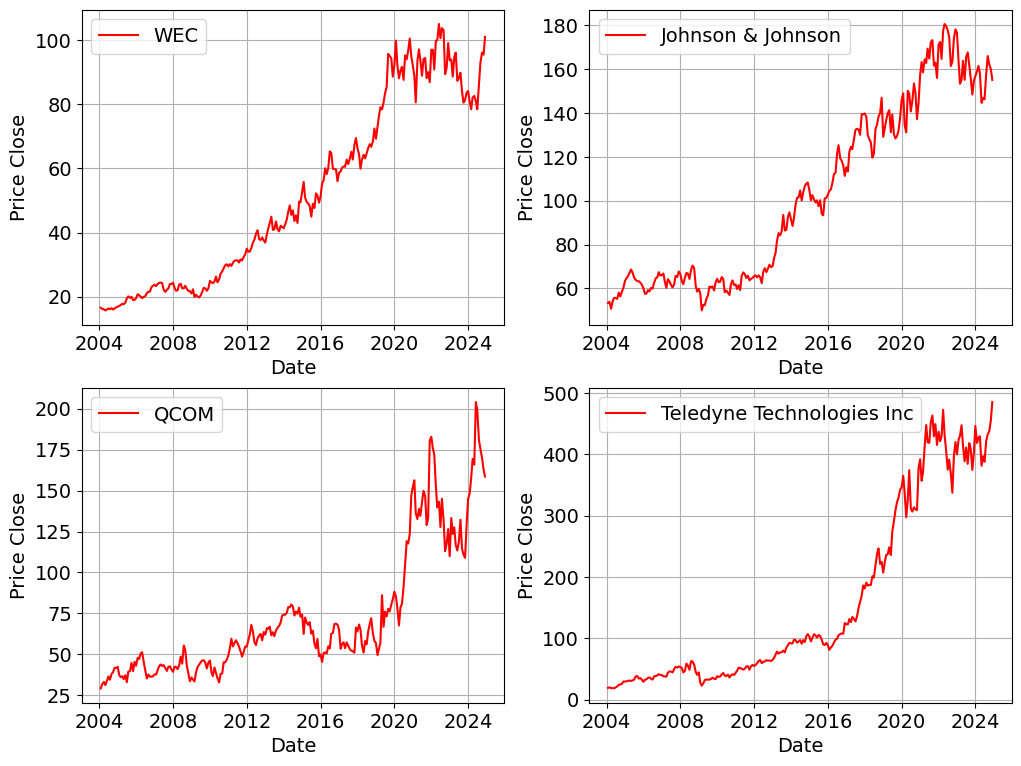

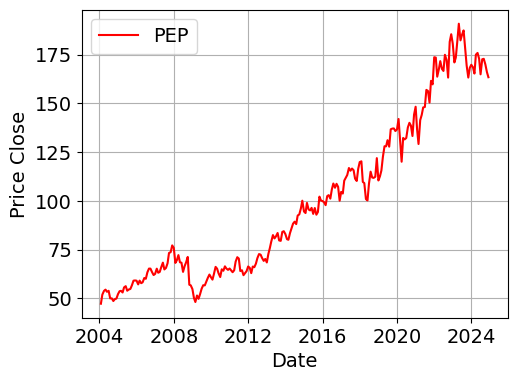

In [4]:
f, axes = plt.subplots(2, 2,figsize=(12,9))
sns.lineplot(x="Date",y="Price Close",data=df_WEC, ax=axes[0,0],c="r",label="WEC")
sns.lineplot(x="Date",y="Price Close",data=df_JNJ, ax=axes[0,1],c="r",label="Johnson & Johnson")
sns.lineplot(x="Date",y="Price Close",data=df_QCOM, ax=axes[1,0],c="r",label="QCOM")
sns.lineplot(x="Date",y="Price Close",data=df_TDY, ax=axes[1,1],c="r",label="Teledyne Technologies Inc")
#axes[1,0].tick_params(rotation=0)
axes[1,0].grid()
axes[0,1].grid()
axes[0,0].grid()
plt.tight_layout
plt.grid()
plt.figure(figsize=(5.5,4))
sns.lineplot(x="Date",y="Price Close",data=df_PEP,c="r",label="PEP")
plt.grid()
plt.tight_layout
#plt.xticks(rotation=0)
plt.legend()

Creo un dataframe contenente il Close Price delle stock.

In [5]:
df_price_close= pd.DataFrame({"Close PEP":df_PEP["Price Close"].values})
df_price_close["Close TDY"] = df_TDY["Price Close"].values
df_price_close["Close WEC"] = df_WEC["Price Close"].values
df_price_close["Close JNJ"] = df_JNJ["Price Close"].values
df_price_close["Close QCOM"] = df_QCOM["Price Close"].values

Creo un dataframe contenente i 1 month returns delle stocks.

In [6]:
df_return_month = pd.DataFrame({"Close PEP":df_PEP["1 Month Total Return"].values})
df_return_month["Close TDY"] = df_TDY["1 Month Total Return"].values
df_return_month["Close WEC"] = df_WEC["1 Month Total Return"].values
df_return_month["Close JNJ"] = df_JNJ["1 Month Total Return"].values
df_return_month["Close QCOM"] = df_QCOM["1 Month Total Return"].values

Ora è interessante visuallizzare la correlazione tra le varie stock sia per il close price, sia per il monthly average return.

Matrici di covaranza e correlazione per il close price
Matrici inverse

In [7]:
cov_close = df_price_close.cov(numeric_only=True).values
corr_close = df_price_close.corr(numeric_only=True).values
inv_corr_close = np.linalg.inv(corr_close)
inv_cov_close = np.linalg.inv(cov_close)

Matrici di covaranza e correlazione per il monthly
Matrici inverse

In [8]:
cov_mon = df_return_month.cov(numeric_only=True).values
corr_mon = df_return_month.corr(numeric_only=True).values
inv_corr_mon = np.linalg.inv(df_return_month.corr(numeric_only=True).values)
inv_cov_mon = np.linalg.inv(cov_mon)

Heat maps per visualizzare le matrici di correlazione

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

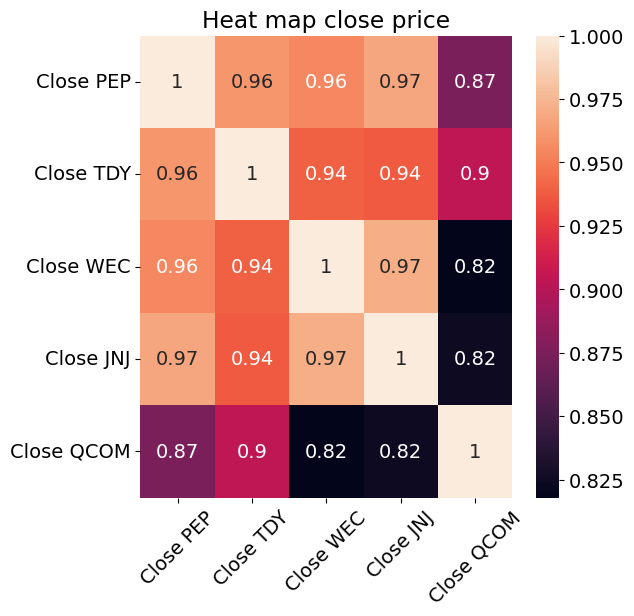

In [9]:
plt.figure(figsize=(6,6))
plt.title("Heat map close price")
sns.heatmap(df_price_close.corr(numeric_only=True),annot=True)
plt.xticks(rotation=45)
plt.tight_layout

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

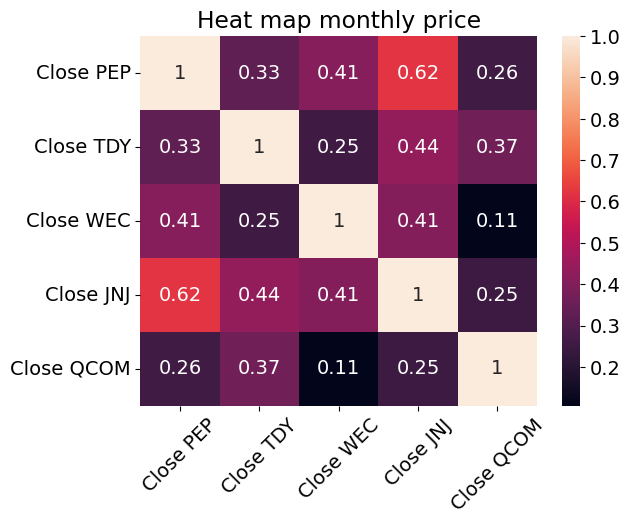

In [10]:
plt.title("Heat map monthly price")
sns.heatmap(df_return_month.corr(numeric_only=True),annot=True)
plt.xticks(rotation=45)
plt.tight_layout

## Punto 2

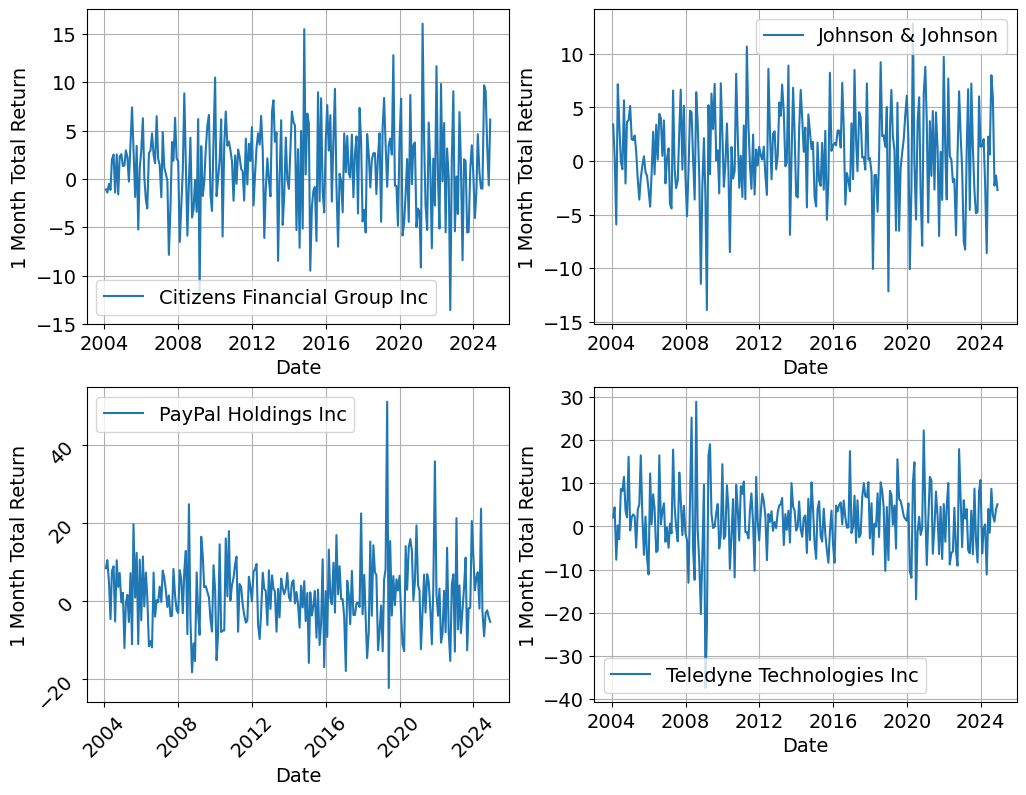

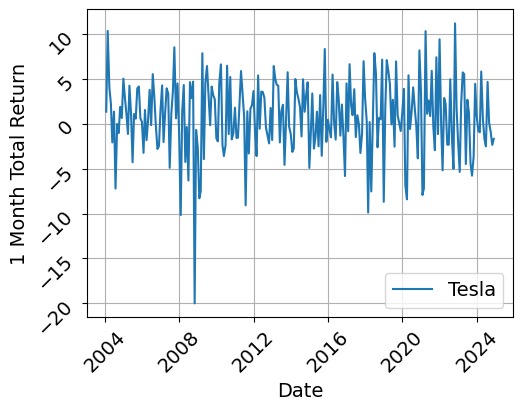

In [11]:
f, axes = plt.subplots(2, 2,figsize=(12,9))
sns.lineplot(x="Date",y="1 Month Total Return",data=df_WEC, ax=axes[0,0],label="Citizens Financial Group Inc")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_JNJ, ax=axes[0,1],label="Johnson & Johnson")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_QCOM, ax=axes[1,0],label="PayPal Holdings Inc")
sns.lineplot(x="Date",y="1 Month Total Return",data=df_TDY, ax=axes[1,1],label="Teledyne Technologies Inc")
axes[1,0].tick_params(rotation=45)
axes[1,0].grid()
axes[0,1].grid()
axes[0,0].grid()
plt.tight_layout
plt.grid()
plt.figure(figsize=(5.5,4))
sns.lineplot(x="Date",y="1 Month Total Return",data=df_PEP,label="Tesla")
#plt.axhline(df_PEP["1 Month Total Return"],c="r")
plt.grid()
plt.tick_params(rotation=45)
plt.tight_layout
plt.legend()

Per fare il moving average posso utilizzare una funzione di pandas che mi fa direttamente il calcolo, la documentazione a riguardo dice che.....

/tmp/ipykernel_25015/3896045492.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=ema_df).set_xticklabels(["",  "2004", "2008", "2012", "2016", "2020", "2024"])


Text(0, 0.5, 'Exponential Moving Average')

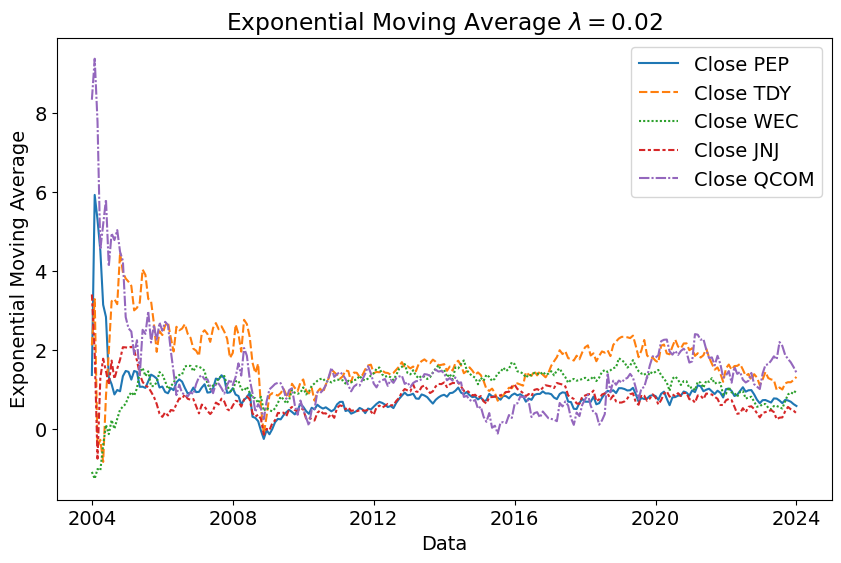

In [12]:
lam = 0.02
ema_df = df_return_month.ewm(alpha=lam).mean()
plt.figure(figsize=(10,6))
plt.title(r"Exponential Moving Average $\lambda = 0.02$")
sns.lineplot(data=ema_df).set_xticklabels(["",  "2004", "2008", "2012", "2016", "2020", "2024"])
plt.xlabel("Data")
plt.ylabel("Exponential Moving Average")

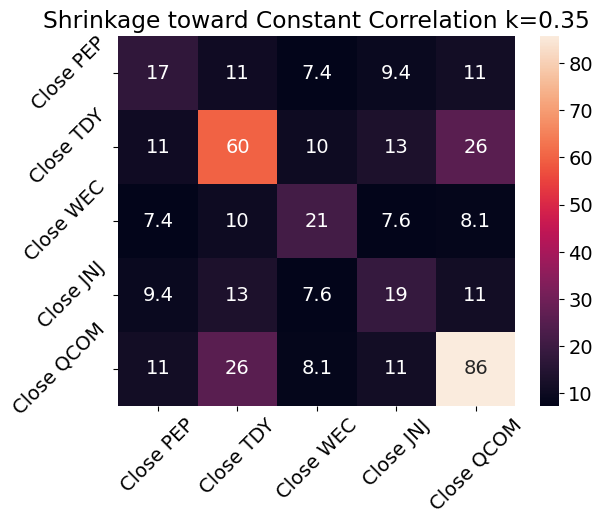

            Close PEP  Close TDY  Close WEC  Close JNJ  Close QCOM
Close PEP   17.302044  10.722719   7.395803   9.367916   11.072342
Close TDY   10.722719  59.939055  10.176018  13.452036   25.741583
Close WEC    7.395803  10.176018  21.269114   7.622941    8.095874
Close JNJ    9.367916  13.452036   7.622941  18.533524   11.331813
Close QCOM  11.072342  25.741583   8.095874  11.331813   85.746390


In [13]:
# Calcoliamo la corelazione media
avg_corr = (np.sum(corr_mon) - len(corr_mon)) / (len(corr_mon) * (len(corr_mon) - 1))

# Matrice di correlazione costante
const_corr = np.full(corr_mon.shape, avg_corr)
np.fill_diagonal(const_corr, 1)

# Shrinkage covariance matrix
k = 0.35
shrinkage_cov = k * (np.outer(np.sqrt(np.diag(cov_mon)), np.sqrt(np.diag(cov_mon))) * const_corr) + (1 - k) * cov_mon

shrinkage_cov = pd.DataFrame(shrinkage_cov, index=df_return_month.columns, columns=df_return_month.columns)
plt.title("Shrinkage toward Constant Correlation k=0.35")
plot = sns.heatmap(shrinkage_cov,annot=True)
plt.tick_params(rotation=45)
plt.tight_layout
plt.show()
print(shrinkage_cov)

## Punto 3

Sappiamo dalla teoria di markovitz senza risk free che
$$\mu_p = \sum_i w_i\mu_i\,,\quad \sigma^2_p = \sum_{i,j}\sigma_{ij} w_i w_j\,,$$
Ora posso definire un lagrangiana $\mathcal{L}$ tale che questa sia minimizzata da un certo $w^*$ (se esiste un minimo)\

Dopo di che i vari valori della lagrangiana possono essere scoperti, a questo punto posso trovare un legame tra la volatilità e il rendimento atteso, da cui posso trovare il portafoglio a minima varianza
L'equazione per il frontiera efficace (Markovitz bullet) è data da 
$$\sigma^2_p = \frac{D\mu_p^2-2B\mu_p+A}{det(M)}\,,$$

$$w^i = \sigma^{ik}\left(\frac{D\mu_p-B}{\det(M)} \mu_k + \frac{A-B\mu_p}{\det(M)} e_k\right)$$

$$
        \lambda = \frac{D\mu_p-B}{\det(M)}\,,\quad
        \gamma = \frac{A-B\mu_p}{\det(M)}\,,
$$
$$
\sigma^{ik}\left(\lambda \mu_k + \gamma e_k\right)\mu_i = \mu_p\,,\quad
        \sigma^{ik}\left(\lambda \mu_k + \gamma e_k\right) e_i = 1\,,
        $$

In [14]:
Rf = 0.03/12 #0.03 == annual return, ma noi vogliamo la monthly quindi divido per 12

mu = df_return_month.mean().to_numpy()



# mu_p è l'expected return del portafoglio, mentre mu dei singoli assets
mu_p = np.dot(inv_cov_mon, mu)

e = np.ones(len(mu_p))
A = inv_cov_mon @ mu @ mu
B = inv_cov_mon @ mu @ e
D = inv_cov_mon @ e @ e
det = A*D - B*B

lam = (D*1)/det
gamma = (1)/det

# w sono i pesi del portafoglio ottimale, massimizando lo sharp ratio.
norm = np.sum(mu_p)
w = mu_p/B

wf = 1 - w@e

print("Pesi portforlio ottimale:", w,"somma w: ",sum(w))
wf

Pesi portforlio ottimale: [ 0.20825531  0.21966803  0.60166139 -0.11487859  0.08529386] somma w:  1.0000000000000002


-2.220446049250313e-16

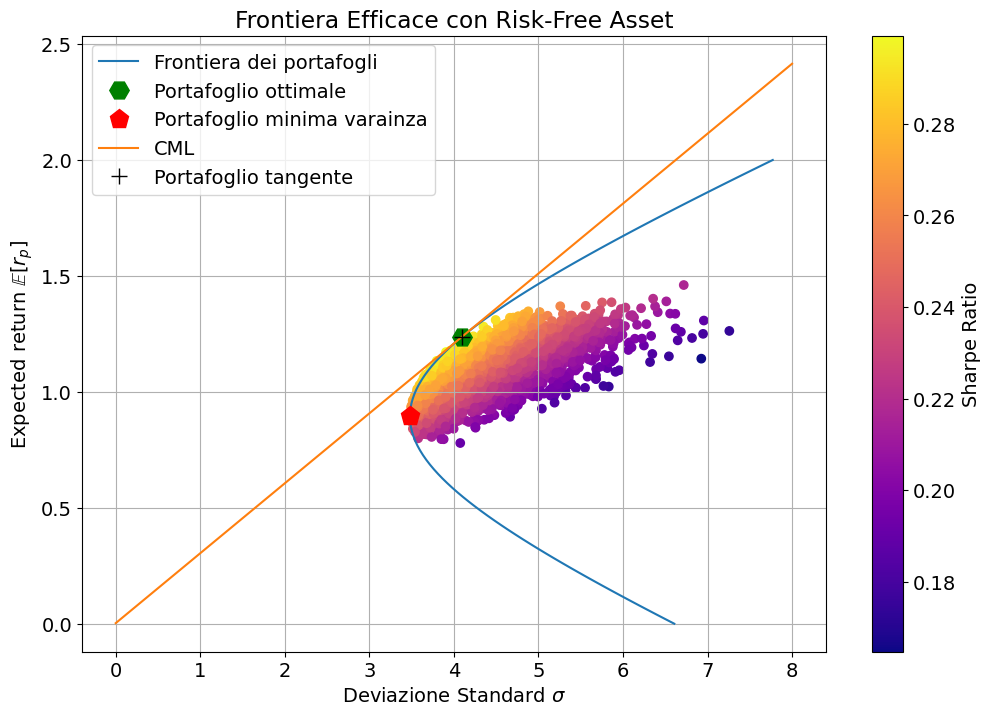

In [15]:
mu_var = np.linspace(0,2,100) 
sigma_var = np.linspace(0,8,100)

mu_opt = mu@w
sigma_opt = np.sqrt(cov_mon @ w @ w)

mu_bullet = []
sigma_bullet = []

for i in range(5000):
    random_weight = np.random.uniform(0, 1, 5)
    random_weight /= np.sum(random_weight)
    mu_bullet.append(random_weight@mu)
    sigma_bullet.append(np.sqrt(cov_mon@random_weight@random_weight))


sharp_ratio = (mu_bullet-Rf*np.ones(len(mu_bullet)))/sigma_bullet

plt.figure(figsize=(12,8))
plt.title("Frontiera Efficace con Risk-Free Asset")

scatter = plt.scatter(x=sigma_bullet, y=mu_bullet, cmap='plasma', c=sharp_ratio)
plt.plot(np.sqrt((D*mu_var**2-2*B*mu_var+A)/det),mu_var,label = "Frontiera dei portafogli")
plt.plot(sigma_opt, mu_opt, color="g", marker="H", markersize=14,ls='', label = "Portafoglio ottimale")

#plt.plot(np.sqrt((D*(mu_var-Rf)**2-2*B*(mu_var-Rf)*(1-wf)+A*(1-wf)**2)/det),mu_var,ls='--',c="r",label = "Frontiera dei portafogli risk-free")


plt.plot(np.sqrt(1/D),B/D, markersize=14, marker = "p",c="r",ls='', label = "Portafoglio minima varainza")
plt.plot(sigma_var,Rf+np.sqrt(A + Rf*(D*Rf-2*B))*sigma_var, label= "CML")
plt.plot(np.sqrt(A+Rf*(-2*B+D*Rf))/np.abs(B-D*Rf),Rf + (A+Rf*(-2*B+D*Rf))/np.abs(B-D*Rf),ls='',markersize=12,marker ="+",c="k", label= "Portafoglio tangente")

# Creo una colorbar per il S.R.
cbar = plt.colorbar(scatter)
cbar.set_label("Sharpe Ratio")

plt.xlabel(r"Deviazione Standard $\sigma$")
plt.ylabel(r"Expected return $\mathbb{E}[r_p] $")

plt.legend()
plt.grid(True)
plt.show()



## Punto 4

## Punto 5

## Punto 6

## 1) Rendimenti Impliciti: 

In [16]:
# il delta può essere 2 oppure possiamo calcolarlo noi con la varianze e rendimenti 
delta = 2 

# Calcolo dei rendimenti impliciti
rendimenti_impliciti = delta * cov_close.dot(w)

print(rendimenti_impliciti)

[ 4489.39745242 16444.61028568  3076.53993151  4365.96370201
  4017.84568996]


## 2) Calcolo rendimento del Portafoglio di Mercato

In [17]:
# Rendimento atteso del portafoglio di mercato
Rendimento_del_PM = np.sum(w * rendimenti_impliciti)

print(Rendimento_del_PM)


6239.473044074543


## Punto 7

In [18]:
# Definizione delle opinioni:
# Opinione Aumento Stock1: "Ci aspettiamo che Stock1 superi il rendimento implicito del mercato del 5%."
# Opinione Riduzione Stock3: "Ci aspettiamo che Stock3 sottoperformi rispetto al rendimento implicito del mercato del 3%."
Opinioni = np.array([rendimenti_impliciti[0] + 0.05, rendimenti_impliciti[2] - 0.03]) 

# Matrice P (opinioni)
P = np.array([[1, 0, 0, 0, 0],   # Opinione su Stock1
              [0, 0, -1, 0, 0]]) # Opinione su Stock3

# Matrice Omega (covarianza delle opinioni)
omega = np.diag([0.0001, 0.0001]) # Assumendo una piccola incertezza

# Calcolo del nuovo rendimento atteso usando Black-Litterman
tau = 1 # Un valore comune per tau τ è un parametro scalare che viene utilizzato per controllare il peso delle opinioni
# degli investitori rispetto alle informazioni di mercato. Esso riflette quanto si considera "forte" la propria opinione
# rispetto ai rendimenti impliciti del mercato.
pi = rendimenti_impliciti

# Formula Black-Litterman
M_inverse = np.linalg.inv(np.linalg.inv(tau * cov_close ) + P.T @ np.linalg.inv(omega) @ P)
Rendimento_atteso_Blacklitterman = M_inverse @ (np.linalg.inv(tau * cov_close ) @ pi + P.T @ np.linalg.inv(omega) @ Opinioni)

print(Rendimento_atteso_Blacklitterman)


[ 4489.44172934  8516.36836408 -3076.50127119  -361.40390434
  5745.83296129]


## Punto 8

## Punto 9 Entropia (opzionale)

Entropia